
<h1 id="tocheading">MuSiCal mutational signature analysis </h1>
<div id="toc"></div>

The code in this notebook is largely taken from https://github.com/parklab/MuSiCal, and readapted for didactic purposes.

In [1]:
# Import some necessary modules
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import time
import scipy as sp
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
# Import MuSiCal
import musical

# Overview 

In this notebook, we outline all the steps in a full pipeline of mutational signature analysis with MuSiCal, except preprocessing. 

# Input data

The input mutation count matrix $X$ should be of size (n_features, n_samples), where, for example, n_features = 96 for SBS signatures.

Here we use a simulated dataset based on PCAWG skin melanomas as an example. The dataset contains 15 SBS signatures. You can replace `X` with your own dataset. 

In [3]:
X = pd.read_csv('./data/simulated_example.Skin.Melanoma.X.csv', index_col=0)

In [5]:
X.head()

,SP124323,SP124281,SP124389,SP124362,SP124394,SP124380,SP124399,SP124311,SP124434,SP124428,...,SP124271,SP124336,SP124441,SP124291,SP82471,SP124353,SP113197,SP83027,SP124351,SP124458
Type,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,60,49,75,129,54,187,223,278,153,184,...,296,163,265,84,101,41,62,62,12,101
A[C>A]C,45,31,57,49,27,94,165,148,98,78,...,198,86,148,59,68,38,44,56,13,37
A[C>A]G,9,4,9,23,15,40,37,38,31,23,...,29,20,31,9,10,2,9,6,4,11
A[C>A]T,32,26,40,86,45,107,150,132,93,97,...,139,81,140,48,53,33,39,36,12,44
C[C>A]A,823,789,60,120,119,145,168,150,92,170,...,271,557,315,86,166,145,120,112,23,79


# *De novo* signature discovery 

*De novo* signature discovery can be performed with `musical.DenovoSig`. An example code is as follows:

In [ ]:
# model = musical.DenovoSig(X,
#                           min_n_components=1, # Minimum number of signatures to test
#                           max_n_components=20, # Maximum number of signatures to test
#                           init='random', # Initialization method
#                           method='mvnmf', # mvnmf or nmf
#                           n_replicates=20, # Number of mvnmf/nmf replicates to run per n_components
#                           ncpu=16, # Number of CPUs to use
#                           max_iter=100000, # Maximum number of iterations for each mvnmf/nmf run
#                           bootstrap=True, # Whether or not to bootstrap X for each run
#                           tol=1e-8, # Tolerance for claiming convergence of mvnmf/nmf
#                           verbose=1, # Verbosity of output
#                           normalize_X=False # Whether or not to L1 normalize each sample in X before mvnmf/nmf
#                         )

# with open('/Output/path/and/filename.pkl', 'wb') as f:
#     pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

For speed here, we have provided the output of `DenovoSig` on this dataset in the `./data/` folder. Let's load it:

In [4]:
with open('data/simulated_example.Skin.Melanoma.model.pkl', 'rb') as f:
    model = pickle.load(f)

In [8]:
# Number of discovered de novo signatures
print(model.n_components)

11


We can inspect the plots for selecting the number of signatures. In this example, 11 *de novo* signatures are discovered, compared to the underlying truth of 15 signatures. Some of the true signatures are too weak, i.e., only present in a few samples or contribute to a small number of mutations. Therefore they are not discovered. However, they can be potentially rescued during the downstream matching step, as *de novo* signatures could be mixtures of multiple true signatures.  

The left panel displays the stability of solutions and the reconstruction errors at different numbers of signatures. The middle panel displays the stability of each discovered signature. The right panel shows our preferred method for selecting n_components, i.e., by comparing n_components with the optimal number of clusters as determined by the gap statistic. Please see our paper for more details. 

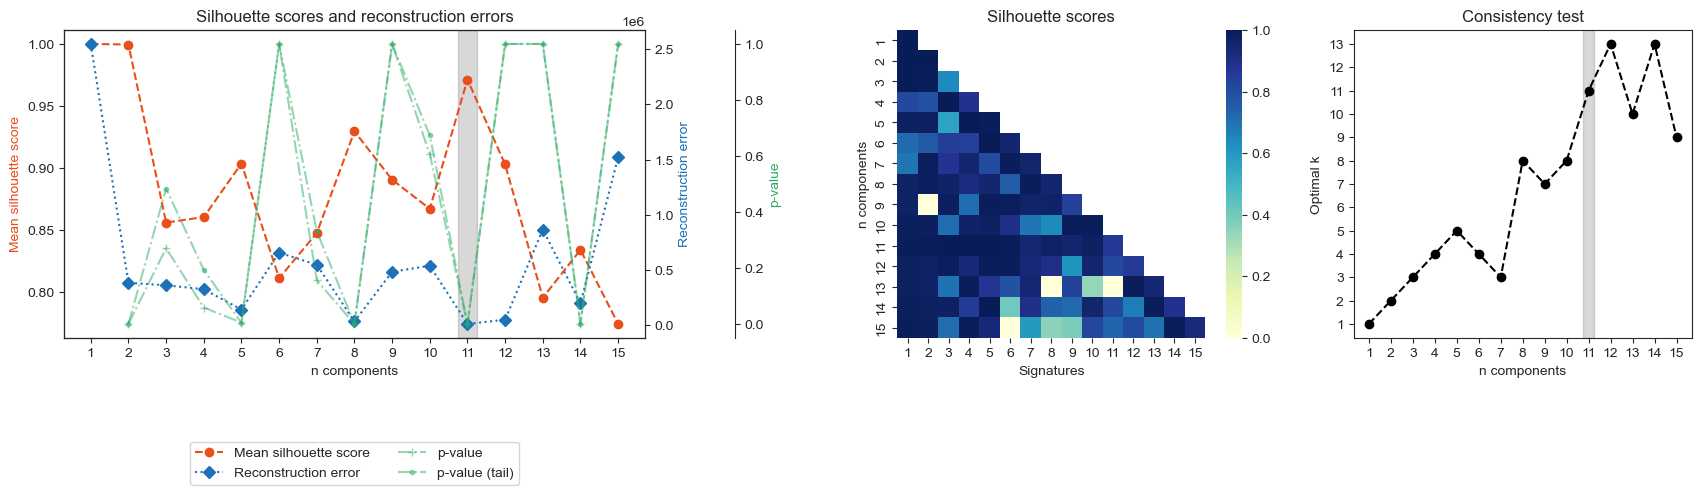

In [9]:
model.plot_selection()

The obtained *de novo* signatures can be visualized. 

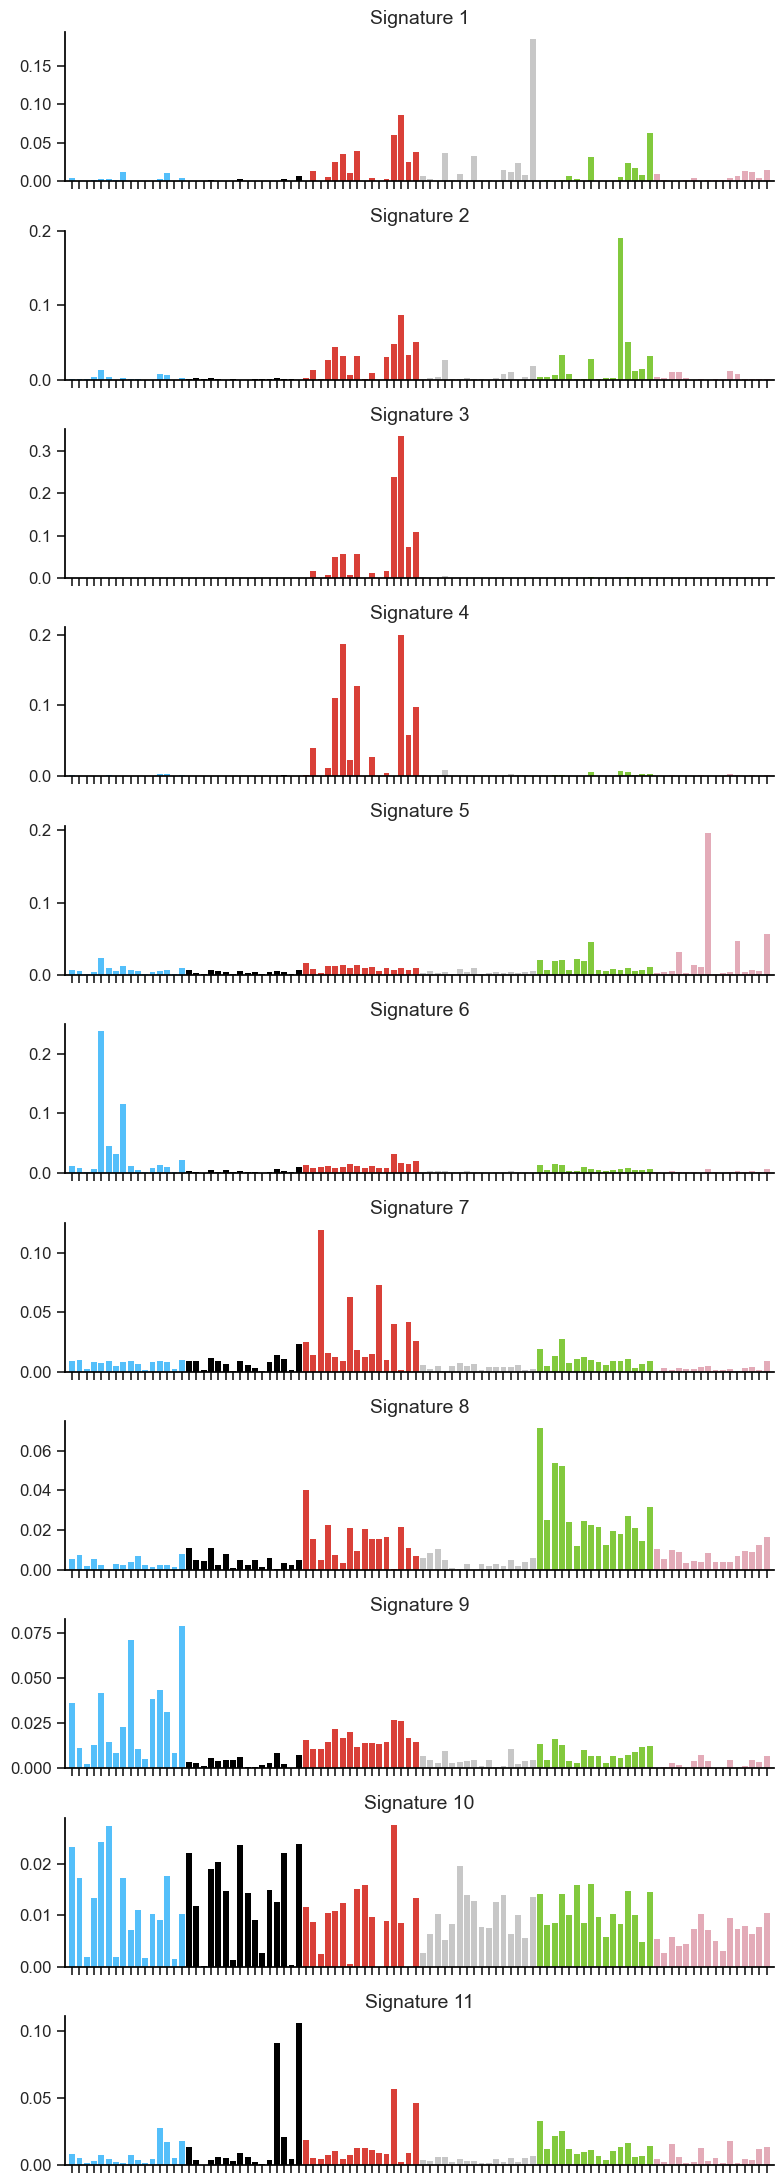

In [5]:
fig = musical.sigplot_bar(model.W)

# Matching and refitting -- signature assignment

Following *de novo* signature discovery, we match *de novo* signatures to the catalog and refit the data against matched signatures to obtain exposures. Matching and refitting are jointly called "signature assignment". 

For the purpose of downstream parameter optimization with data-driven simulations, here we perform matching and refitting on a 2-dimensional grid of parameters. The two parameters correspond to the two likelihood thresholds for likelihood-based sparse NNLS used in matching and refitting, respectively. 

The following grid will be used for both matching and refitting thresholds:

In [24]:
thresh_grid = np.array([
    0.0001, 0.0002, 0.0005,
    0.001, 0.002, 0.005,
    0.01, 0.02, 0.05,
    0.1, 0.2, 0.5,
    1., 2., 5.
])

We then load the signature catalog to be used.

In [25]:
catalog = musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS')
W_catalog = catalog.W
print(W_catalog.shape[1])

84


Matching and refitting on the 2-dimensional grid can then be performed with:


In [ ]:
# model.assign_grid(W_catalog,
#                   method_assign='likelihood_bidirectional', # Method for performing matching and refitting
#                   thresh_match_grid=thresh_grid, # Grid of threshold for matchinng
#                   thresh_refit_grid=thresh_grid, # Grid of threshold for refitting
#                   thresh_new_sig=0.0, # De novo signatures with reconstructed cosine similarity below this threshold will be considered novel
#                   connected_sigs=False, # Whether or not to force connected signatures to co-occur
#                   clean_W_s=False # An optional intermediate step to avoid overfitting to small backgrounds in de novo signatures for 96-channel SBS signatures
#                  )
# 


In `model` that we loaded above, this assignment step is already performed. So we can look at the results. The signatures and exposures after assignment are called `W_s` and `H_s`, respectively, where `s` stands for sparse.
First, let's look at the result with relatively small thresholds. Here, the key of the dictionary `W_s_grid` and `H_s_grid` is `(thresh_match, thresh_refit)`. 

In [29]:
print(model.W_s_grid[(0.0001, 0.0001)].shape)
print(model.H_s_grid[(0.0001, 0.0001)].shape)

(96, 53)
(53, 107)


We see that, with very small thresholds, too many (53) signatures are assigned. 

Next, let's look at the result with relatively large thresholds. 

In [30]:
print(model.W_s_grid[(1.0, 1.0)].shape)
print(model.H_s_grid[(1.0, 1.0)].shape)

(96, 5)
(5, 107)


In this case, too few (5) signatures are assigned. 

Therefore, it is important to choose the appropriate thresholds for matching and refitting. 

# Parameter optimization with *in silico* validation

MuSiCal utilizes the *in silico* validation module to optimize the matching and refitting thresholds using a grid search. This step can be performed with:

In [31]:
# model.validate_grid(validate_n_replicates=1, # Number of simulation replicates to perform for each grid point
#                     grid_selection_method='pvalue', # Method for selecting the best grid point
#                     grid_selection_pvalue_thresh=0.05 # Threshold used for selecting the best grid point
#                    )

For speed here, we will use the `model` we have loaded has already been called for parameter optimization.

In [32]:
print(model.best_grid_point)
print(model.thresh_match)
print(model.thresh_refit)

(np.float64(0.02), np.float64(0.001))
0.02
0.001


The final matched signatures and signature assignments are:

In [6]:
W_s = model.W_s
H_s = model.H_s

In order to evaluate the final result, let's load the true signatures and exposures from which this dataset is simulated. 

In [15]:
W_true = pd.read_csv('./data/simulated_example.Skin.Melanoma.W_true.csv', index_col=0)
H_true = pd.read_csv('./data/simulated_example.Skin.Melanoma.H_true.csv', index_col=0)

We see that we have found the correct 15 signatures:

In [35]:
print(W_s.columns.tolist())
print(W_true.columns.tolist())
print(W_s.columns.tolist() == W_true.columns.tolist())

['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS7a', 'SBS7b', 'SBS7c', 'SBS7d', 'SBS13', 'SBS17a', 'SBS17b', 'SBS18', 'SBS37', 'SBS38', 'SBS55']
['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS7a', 'SBS7b', 'SBS7c', 'SBS7d', 'SBS13', 'SBS17a', 'SBS17b', 'SBS18', 'SBS37', 'SBS38', 'SBS55']
True


We can also compare `H_true` with `H_s` to evaluate the signature assignment result. 

In [36]:
H_true_reindexed = H_true.reindex(H_s.index).fillna(0)

In [37]:
TP = np.logical_and(H_true_reindexed > 0, H_s > 0).sum().sum()
FP = np.logical_and(H_true_reindexed == 0, H_s > 0).sum().sum()
TN = np.logical_and(H_true_reindexed == 0, H_s == 0).sum().sum()
FN = np.logical_and(H_true_reindexed > 0, H_s == 0).sum().sum()
P = TP + FN
N = TN + FP
print(TP, FP, TN, FN, P, N)

423 3 1178 1 424 1181


In [38]:
print('Sensitivity = %.3g' % (TP/P))
print('False positive rate = %.3g' % (FP/N))

Sensitivity = 0.998
False positive rate = 0.00254


We have achieved good sensitivity while having low false positive rate. 

# Comments 

1. *In silico* validation does not need to be performed on a grid. To perform a single validation, you can use `model.validate(W_s=W_s, H_s=H_s)`, where `model` is an object of the class `DenovoSig`, and a single signature assignment result to be validated (i.e., `W_s` and `H_s`) should be provided. We used this functionality to validate the signature assignments obtained by the PCAWG consortium in the paper. 

2. Similarly, there is a function `model.assign()` for performing a single signature assignment at some fixed matching and refitting thresholds. 

3. We have described the approach of parameter optimization through a joint two-dimensional grid search above. Alternatively, you can perform two stepwise one-dimensional grid searches for matching and refitting thresholds, respectively. 
```
# Optimizing matching threshold
model.assign_grid(
    W_catalog, 
    method_assign='likelihood_bidirectional',
    thresh_match_grid=thresh_grid,
    thresh_refit_grid=np.array([0.0001]),
    thresh_new_sig=0.0
)
model.validate_grid()
best_thresh_match = model.thresh_match
# Optimizing refitting threshold
model.assign_grid(
    W_catalog, 
    method_assign='likelihood_bidirectional',
    thresh_match_grid=np.array([best_thresh_match]),
    thresh_refit_grid=thresh_grid,
    thresh_new_sig=0.0
)
model.validate_grid()
```